In [1]:
import matplotlib.pyplot as plt

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, linewidth=0.5, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

# 예시:
# predicted와 example_output이 [1, 1, 30, 30] 크기의 텐서라고 가정
#show_grid_side_by_side(task_input, task_output, predicted)


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataloader_sw import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from math import sqrt

def cast_tuple(val, depth):
    return val if isinstance(val, tuple) else (val,) * depth

class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        std = torch.var(x, dim=1, unbiased=False, keepdim=True).sqrt()
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) / (std + self.eps) * self.g + self.b

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x))

## 컨볼루션 임베딩
class Embedding(nn.Module):
    def __init__(self, embed_dim, kernel_size, stride, padding, dropout=0.0):
        super(Embedding, self).__init__()
        self.embedding = nn.Conv2d(1, 
                                   embed_dim, 
                                   kernel_size=kernel_size, 
                                   stride=stride, 
                                   padding=padding)
        
    def forward(self, x):
        return self.embedding(x)

## 인코더
class MultiheadAttention(nn.Module):
    def __init__(self, *, dim=124, num_heads=4, dropout=0.1) -> None:
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        
    
    def forward(self, x):
        x = self.norm(x)
        x, _ = self.attn(x, x, x)
        return x

    
class FeedForwardNetwork(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

    
class Encoder(nn.Module):
    def __init__(self, dim=124, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ModuleList([
                MultiheadAttention(dim=dim, num_heads=num_heads, dropout=dropout),
                FeedForwardNetwork(dim=dim, hidden_dim=dim * 4, dropout=dropout)
            ]) for _ in range(num_layers)
        ])

    def forward(self, x):
        height = x.shape[2]
        x = rearrange(x, 'b c h w -> b (h w) c')

        for attn, mlp in self.layers:
            x = attn(x)
            x = mlp(x)

        x = rearrange(x, 'b (h w) c -> b c h w', h=height)
        return x

    
class Head(nn.Module):
    def __init__(self, input_dim = 256 ,dim=128, num_classes=11):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(input_dim , dim, kernel_size=1),  
            nn.Conv2d(dim, num_classes, kernel_size=1)
        )
        
    def forward(self, x):
        return self.layers(x)
## 디코더
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class Decoder(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(Decoder, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

class ARC_Net(nn.Module):
    def __init__(
        self, 
        *,
        dim=128,
        num_heads=4,
        num_layers=4,
        num_classes=11,
        dropout=0.1,
        kernel_stride_padding=((1, 1, 0), (3, 1, 1))
    ) -> None:
        super().__init__()
        self.stages = nn.ModuleList()

        # 각 커널 크기, 스트라이드, 패딩을 튜플로 묶어서 처리
        for (kernel_size, stride, padding) in kernel_stride_padding:
            self.stages.append(
                nn.ModuleList([
                    Embedding(embed_dim=dim, kernel_size=kernel_size, stride=stride, padding=padding, dropout=dropout),
                    Encoder(dim=dim, num_heads=num_heads, num_layers=num_layers, dropout=dropout)
                ])
            )
        
        # Decoder를 통해 attention을 적용하여 결합
        self.decoder = Decoder(gate_channels = dim * len(kernel_stride_padding))  
        self.head = Head(input_dim=dim * len(kernel_stride_padding), dim=dim, num_classes=num_classes)

    def forward(self, x):
        all_outputs = []

        # 각 커널 크기, 스트라이드, 패딩에 대해 독립적으로 처리
        for embedding, encoder in self.stages:
            scale_x = embedding(x)
            scale_x = encoder(scale_x)
            all_outputs.append(scale_x)

        # 다양한 커널 크기에서 추출된 특징을 병합
        x = torch.cat(all_outputs, dim=1)
        
        # Decoder를 통해 어텐션 적용 및 결과와 결합
        x = self.decoder(x)
        # print("ch_sp:",x.shape)
        
        # 병합된 특징을 헤드에 전달
        x = self.head(x)
        return x


In [4]:
# 모델 생성 및 출력
model_args = {
        'dim': 128,
        'num_heads': 4,
        'num_layers': 2,
        'num_classes': 11,
        'dropout': 0.1,
        'kernel_stride_padding': ((1, 1, 0), (3, 1, 1), (5, 1, 2), (7, 1, 3))
    }

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ARC_Net(**model_args).to(device)
# 입력 텐서 생성
x = torch.randn(10, 1, 30, 30).to(device)

print(model(x).shape)

torch.Size([10, 11, 30, 30])


In [6]:
from thop import profile
from thop import clever_format

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
outer_model = ARC_Net(**model_args).to(device)

# 입력 텐서 생성
x = torch.randn(1, 1, 30, 30).to(device)

# FLOPs 및 파라미터 수 계산
try:
    flops, params = profile(outer_model, inputs=(x,))
    flops, params = clever_format([flops, params], "%.3f")
    print(f"FLOPs: {flops}")
    print(f"파라미터 수: {params}")
except Exception as e:
    print(f"Error during profiling: {e}")
    print(f"Input shape: {x.shape}")
from torchinfo import summary

summary(outer_model, input_size=(1, 1, 30, 30))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
FLOPs: 760.218M
파라미터 수: 866.311K


Layer (type:depth-idx)                                       Output Shape              Param #
ARC_Net                                                      [1, 11, 30, 30]           --
├─ModuleList: 1-1                                            --                        --
│    └─ModuleList: 2-1                                       --                        --
│    │    └─Embedding: 3-1                                   [1, 128, 30, 30]          256
│    │    └─Encoder: 3-2                                     [1, 128, 30, 30]          396,032
│    └─ModuleList: 2-2                                       --                        --
│    │    └─Embedding: 3-3                                   [1, 128, 30, 30]          1,280
│    │    └─Encoder: 3-4                                     [1, 128, 30, 30]          396,032
│    └─ModuleList: 2-3                                       --                        --
│    │    └─Embedding: 3-5                                   [1, 128, 30, 30]    

In [7]:
# from bw_net_maml import BWNet_MAML

# model = BWNet_MAML(embed_size=1).to(device)

# # 입력 텐서 생성
# x = torch.randn(1, 1, 30, 30).to(device)

# # FLOPs 및 파라미터 수 계산
# try:
#     flops, params = profile(model, inputs=(x,))
#     flops, params = clever_format([flops, params], "%.3f")
#     print(f"FLOPs: {flops}")
#     print(f"파라미터 수: {params}")
# except Exception as e:
#     print(f"Error during profiling: {e}")
#     print(f"Input shape: {x.shape}")

In [8]:
import torch
#weight = torch.ones(11).to('cuda')
#weight[0] = 0.0005  # 0은 무시
#print(weight)

: 

Train Loop
N개의 샘플 배치를 불러온다.
1. 각 샘플에 대해 이너 모델을 아우터 모델에서 복사해 로스를 계산한다.
2. 이너 모델의 파라미터를 업데이트한다.
3. 업데이트 된 이너 모델을 바탕으로 테스크 셋에 대한 로스를 계산한다.
4. 테스크 셋에 대한 로스를 저장한다.
5. 모든 테스크 셋에 대해 로스가 구해지면 아우터 모델의 파라미터를 업데이트한다.

Using cuda device
Epoch 1/500


Validation:  89%|████████▉ | 8/9 [03:51<00:27, 27.43s/it]

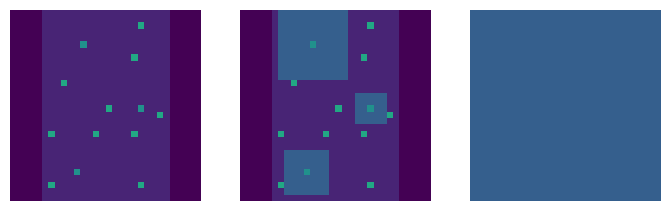

Validation: 100%|██████████| 9/9 [04:03<00:00, 27.01s/it]


Epoch 1/500, Loss: 2.3968732813662164, Accuracy: 37.27046642643252%
Epoch 2/500


Validation:  89%|████████▉ | 8/9 [03:40<00:25, 25.93s/it]

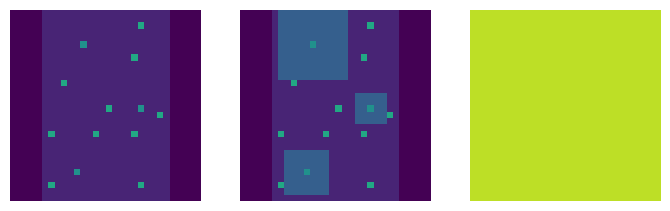

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.62s/it]


Epoch 2/500, Loss: 2.4558759186603574, Accuracy: 37.41866720803939%
Epoch 3/500


Validation:  89%|████████▉ | 8/9 [03:39<00:26, 26.01s/it]

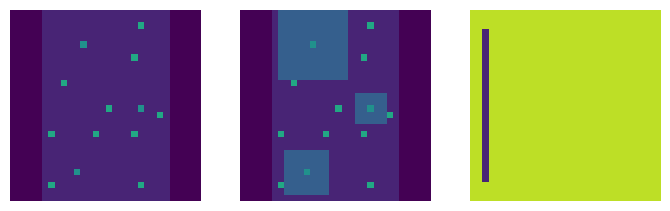

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.58s/it]


Epoch 3/500, Loss: 2.338247549846804, Accuracy: 38.020605999086435%
Epoch 4/500


Validation:  89%|████████▉ | 8/9 [03:39<00:25, 25.97s/it]

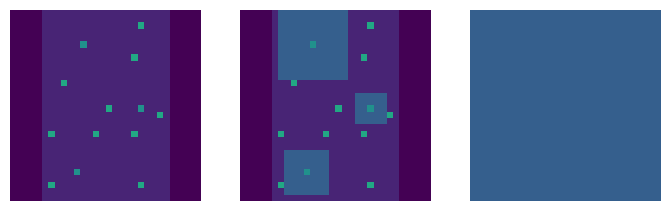

Validation: 100%|██████████| 9/9 [03:49<00:00, 25.53s/it]


Epoch 4/500, Loss: 2.3407535547288334, Accuracy: 38.974775414911434%
Epoch 5/500


Validation:  89%|████████▉ | 8/9 [03:38<00:26, 26.02s/it]

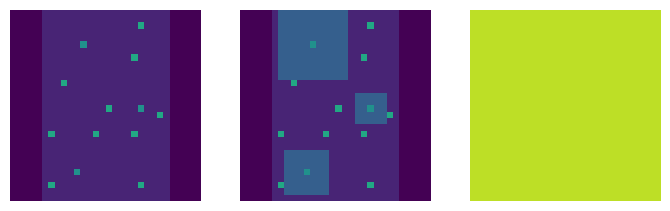

Validation: 100%|██████████| 9/9 [03:49<00:00, 25.51s/it]


Epoch 5/500, Loss: 2.3529292925445446, Accuracy: 36.74465817388215%
Epoch 6/500


Validation:  89%|████████▉ | 8/9 [03:39<00:26, 26.09s/it]

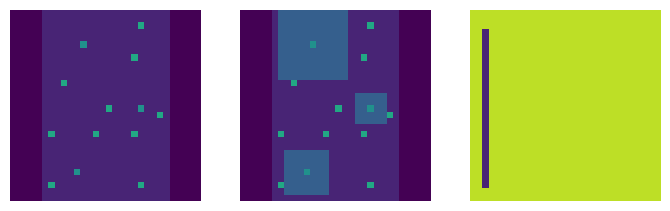

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.60s/it]


Epoch 6/500, Loss: 2.4473277653316323, Accuracy: 37.45927016190428%
Epoch 7/500


Validation:  89%|████████▉ | 8/9 [03:39<00:26, 26.07s/it]

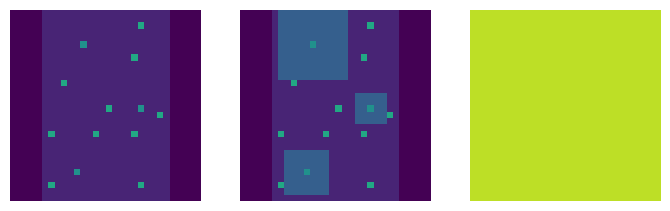

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.58s/it]


Epoch 7/500, Loss: 2.3252861324813314, Accuracy: 36.19144292747298%
Epoch 8/500


Validation:  89%|████████▉ | 8/9 [03:40<00:26, 26.15s/it]

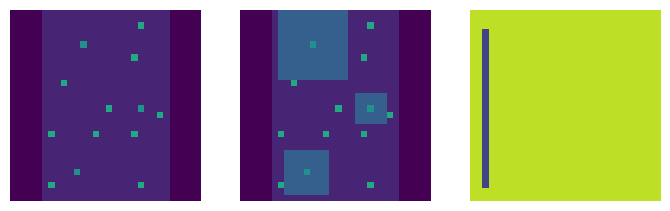

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.64s/it]


Epoch 8/500, Loss: 2.3616740322340646, Accuracy: 36.77815561082069%
Epoch 9/500


Validation:  89%|████████▉ | 8/9 [03:40<00:26, 26.08s/it]

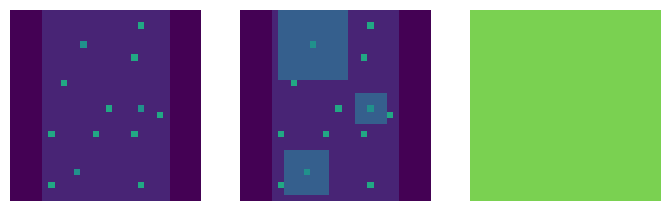

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.66s/it]


Epoch 9/500, Loss: 2.404225472618686, Accuracy: 35.506268081002894%
Epoch 10/500


Validation:  89%|████████▉ | 8/9 [03:39<00:25, 25.78s/it]

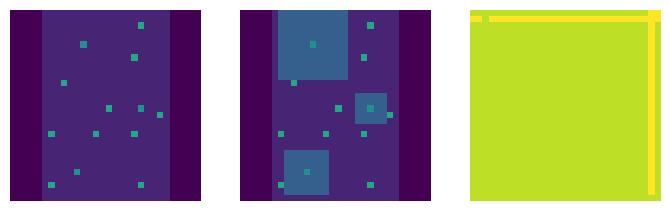

Validation: 100%|██████████| 9/9 [03:49<00:00, 25.53s/it]


Epoch 10/500, Loss: 2.362800541669486, Accuracy: 36.77308024158758%
Epoch 11/500


Validation:  89%|████████▉ | 8/9 [03:38<00:25, 25.91s/it]

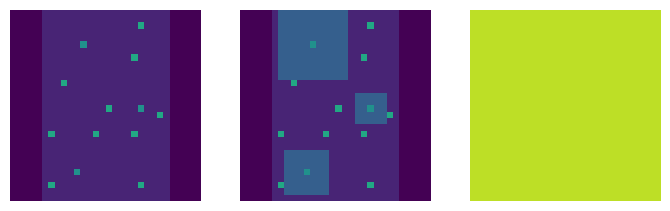

Validation: 100%|██████████| 9/9 [03:49<00:00, 25.47s/it]


Epoch 11/500, Loss: 2.376197058858621, Accuracy: 36.573110693802974%
Epoch 12/500


Validation:  89%|████████▉ | 8/9 [03:38<00:25, 25.88s/it]

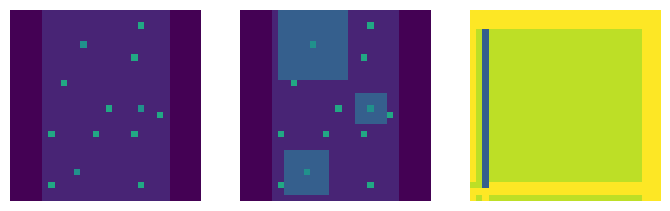

Validation: 100%|██████████| 9/9 [03:49<00:00, 25.49s/it]


Epoch 12/500, Loss: 2.334783130869945, Accuracy: 36.50002537684617%
Epoch 13/500


Validation:  89%|████████▉ | 8/9 [03:39<00:26, 26.01s/it]

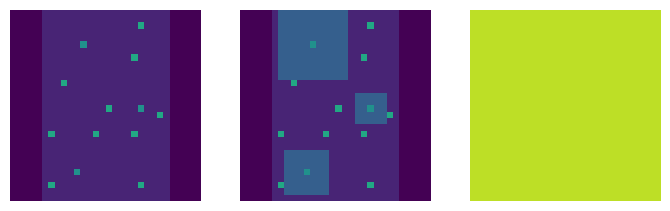

Validation: 100%|██████████| 9/9 [03:49<00:00, 25.55s/it]


Epoch 13/500, Loss: 2.3180879957636105, Accuracy: 37.97898797137492%
Epoch 14/500


Validation:  89%|████████▉ | 8/9 [03:40<00:26, 26.11s/it]

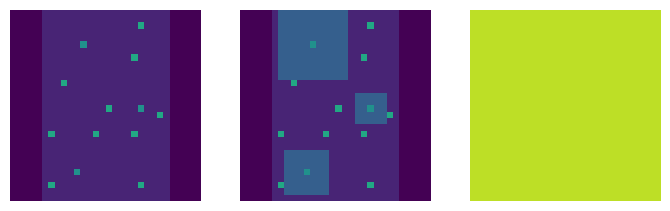

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.61s/it]


Epoch 14/500, Loss: 2.3457340774501994, Accuracy: 35.61386590874486%
Epoch 15/500


Validation:  89%|████████▉ | 8/9 [03:39<00:25, 25.96s/it]

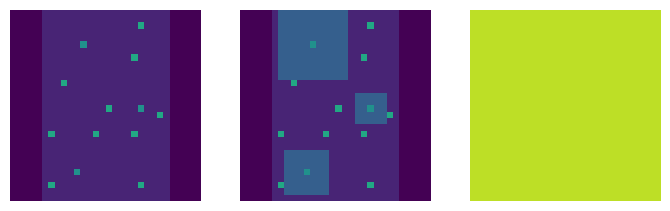

Validation: 100%|██████████| 9/9 [03:49<00:00, 25.54s/it]


Epoch 15/500, Loss: 2.4057891671868097, Accuracy: 34.68710348677866%
Epoch 16/500


Validation:  89%|████████▉ | 8/9 [03:40<00:26, 26.10s/it]

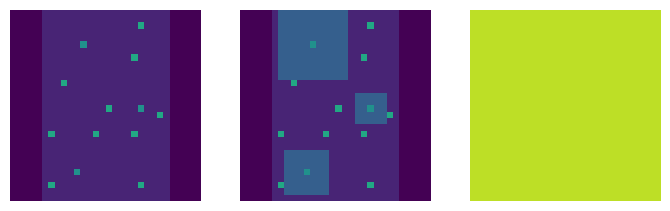

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.66s/it]


Epoch 16/500, Loss: 2.3522503688967027, Accuracy: 37.30396386337106%
Epoch 17/500


Validation:  89%|████████▉ | 8/9 [03:39<00:25, 25.94s/it]

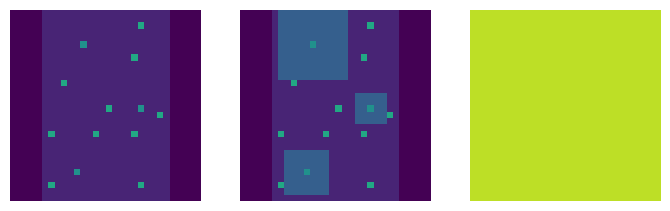

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.58s/it]


Epoch 17/500, Loss: 2.365854745833003, Accuracy: 37.92112876211744%
Epoch 18/500


Validation:  89%|████████▉ | 8/9 [03:40<00:25, 25.97s/it]

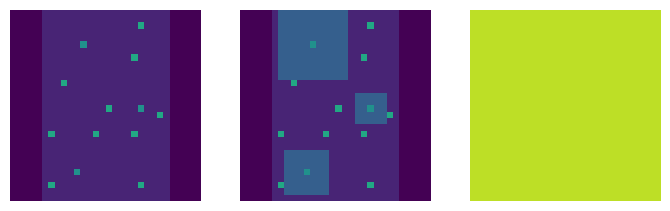

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.61s/it]


Epoch 18/500, Loss: 2.3109255219700797, Accuracy: 37.32832563569%
Epoch 19/500


Validation:  89%|████████▉ | 8/9 [03:38<00:25, 25.86s/it]

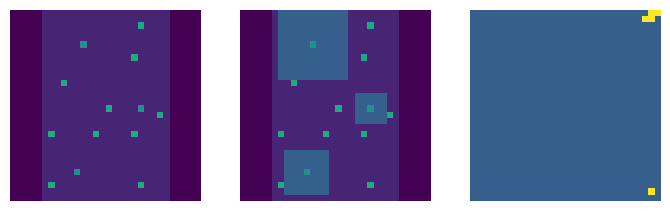

Validation: 100%|██████████| 9/9 [03:49<00:00, 25.48s/it]


Epoch 19/500, Loss: 2.3637286057620175, Accuracy: 37.24711972796021%
Epoch 20/500


Validation:  89%|████████▉ | 8/9 [03:41<00:26, 26.35s/it]

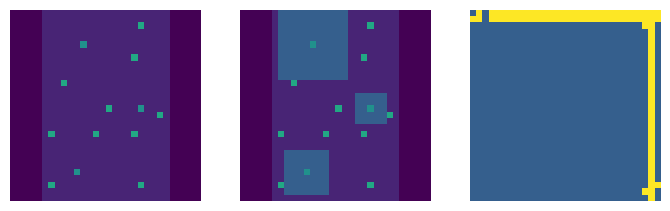

Validation: 100%|██████████| 9/9 [03:51<00:00, 25.76s/it]


Epoch 20/500, Loss: 2.454684264762305, Accuracy: 38.39212302695021%
Epoch 21/500


Validation:  89%|████████▉ | 8/9 [03:42<00:26, 26.47s/it]

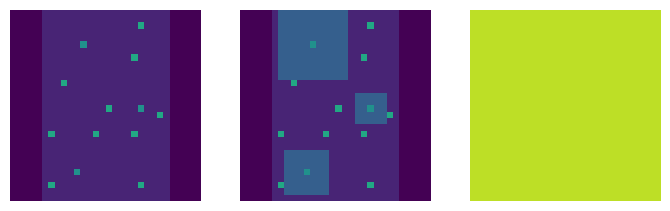

Validation: 100%|██████████| 9/9 [03:53<00:00, 25.93s/it]


Epoch 21/500, Loss: 2.301573989214931, Accuracy: 38.39719839618332%
Epoch 22/500


Validation:  89%|████████▉ | 8/9 [03:40<00:26, 26.16s/it]

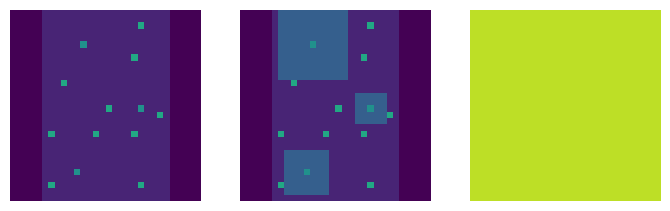

Validation: 100%|██████████| 9/9 [03:51<00:00, 25.68s/it]


Epoch 22/500, Loss: 2.4090542385003446, Accuracy: 35.46871034867787%
Epoch 23/500


Validation:  89%|████████▉ | 8/9 [03:41<00:26, 26.20s/it]

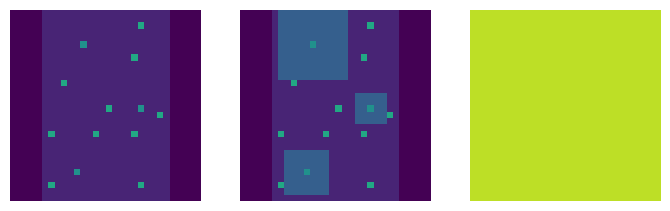

Validation: 100%|██████████| 9/9 [03:51<00:00, 25.71s/it]


Epoch 23/500, Loss: 2.337332166322376, Accuracy: 36.75683906004162%
Epoch 24/500


Validation:  89%|████████▉ | 8/9 [03:40<00:25, 25.98s/it]

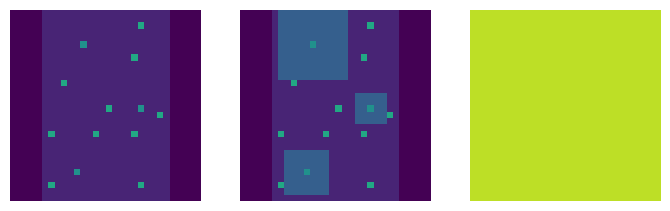

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.66s/it]


Epoch 24/500, Loss: 2.334493005759392, Accuracy: 38.76770035020048%
Epoch 25/500


Validation:  89%|████████▉ | 8/9 [03:40<00:25, 25.97s/it]

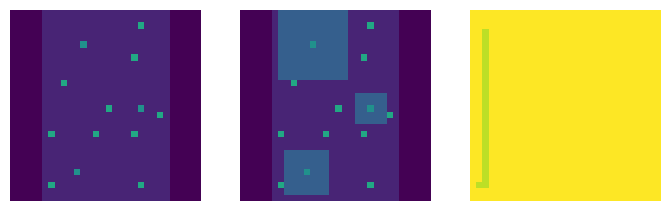

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.63s/it]


Epoch 25/500, Loss: 2.3458078408298175, Accuracy: 36.81571334314572%
Epoch 26/500


Validation:  89%|████████▉ | 8/9 [03:39<00:25, 25.98s/it]

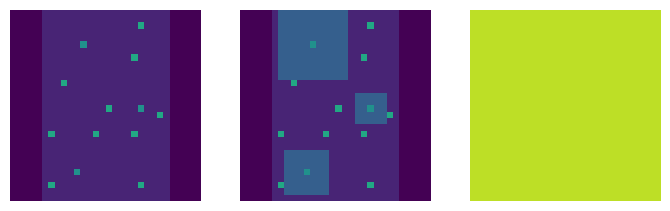

Validation: 100%|██████████| 9/9 [03:49<00:00, 25.55s/it]


Epoch 26/500, Loss: 2.3960937036819274, Accuracy: 37.98913870984114%
Epoch 27/500


Validation:  89%|████████▉ | 8/9 [03:39<00:25, 25.93s/it]

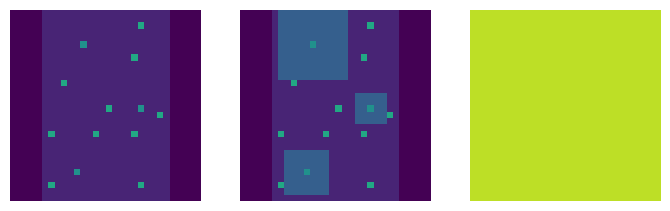

Validation: 100%|██████████| 9/9 [03:49<00:00, 25.53s/it]


Epoch 27/500, Loss: 2.310967572833587, Accuracy: 38.12211338374867%
Epoch 28/500


Validation:  89%|████████▉ | 8/9 [03:39<00:26, 26.05s/it]

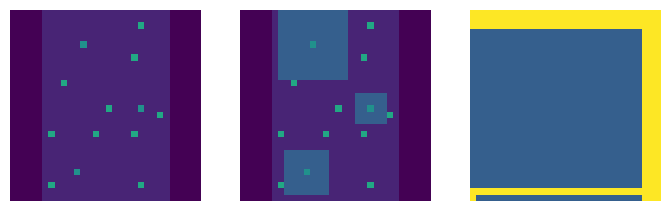

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.57s/it]


Epoch 28/500, Loss: 2.3432581406220048, Accuracy: 37.449119423438056%
Epoch 29/500


Validation:  89%|████████▉ | 8/9 [03:41<00:26, 26.20s/it]

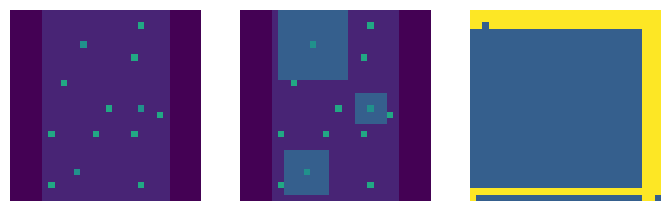

Validation: 100%|██████████| 9/9 [03:51<00:00, 25.73s/it]


Epoch 29/500, Loss: 2.337057077372558, Accuracy: 37.73232502664569%
Epoch 30/500


Validation:  89%|████████▉ | 8/9 [03:40<00:26, 26.05s/it]

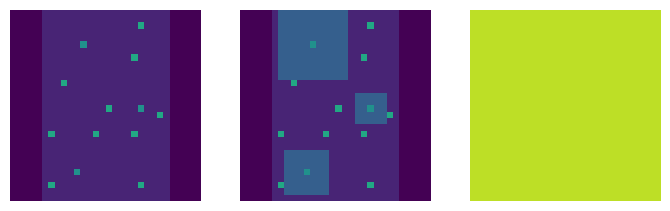

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.61s/it]


Epoch 30/500, Loss: 2.3426598952038478, Accuracy: 37.463330457290766%
Epoch 31/500


Validation:  89%|████████▉ | 8/9 [03:39<00:25, 25.91s/it]

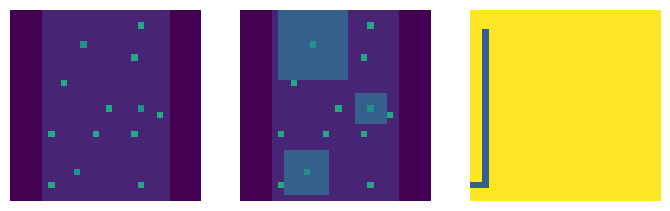

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.57s/it]


Epoch 31/500, Loss: 2.347004478899562, Accuracy: 36.44521138912856%
Epoch 32/500


Validation:  89%|████████▉ | 8/9 [03:39<00:25, 25.95s/it]

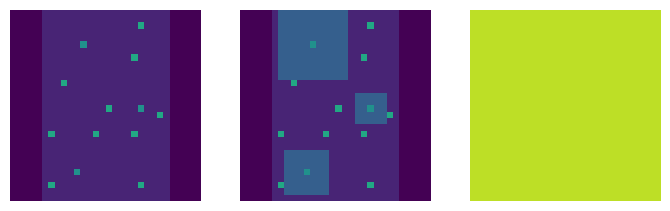

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.60s/it]


Epoch 32/500, Loss: 2.3895965256952727, Accuracy: 38.415469725422525%
Epoch 33/500


Validation:  89%|████████▉ | 8/9 [03:38<00:25, 25.92s/it]

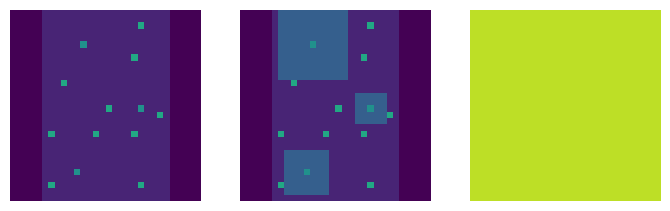

Validation: 100%|██████████| 9/9 [03:49<00:00, 25.45s/it]


Epoch 33/500, Loss: 2.3512107500882022, Accuracy: 36.513221336852254%
Epoch 34/500


Validation:  89%|████████▉ | 8/9 [03:38<00:25, 25.90s/it]

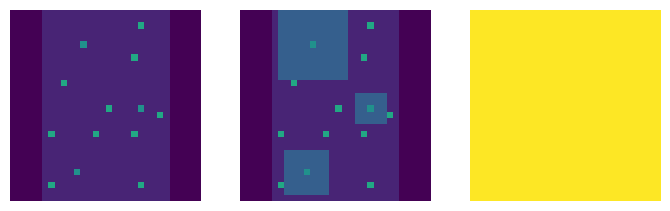

Validation: 100%|██████████| 9/9 [03:49<00:00, 25.46s/it]


Epoch 34/500, Loss: 2.355814951131907, Accuracy: 36.54570369994417%
Epoch 35/500


Validation:  89%|████████▉ | 8/9 [03:40<00:26, 26.16s/it]

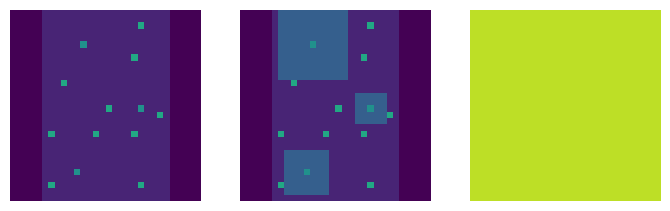

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.64s/it]


Epoch 35/500, Loss: 2.3750592107420037, Accuracy: 37.01263766939045%
Epoch 36/500


Validation:  89%|████████▉ | 8/9 [03:40<00:26, 26.08s/it]

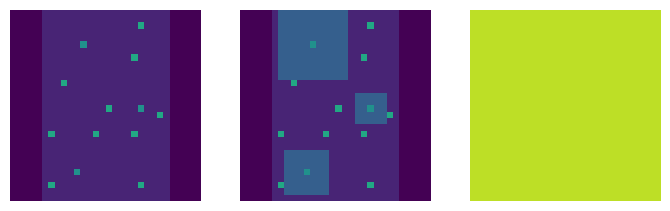

Validation: 100%|██████████| 9/9 [03:51<00:00, 25.67s/it]


Epoch 36/500, Loss: 2.351650233627219, Accuracy: 35.86966451809369%
Epoch 37/500


Validation:  89%|████████▉ | 8/9 [03:40<00:26, 26.28s/it]

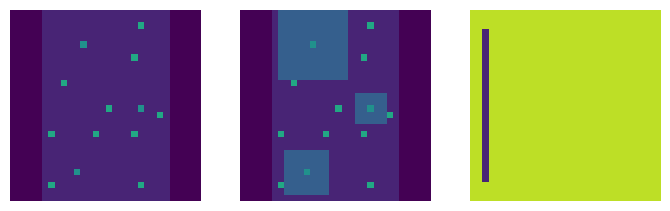

Validation: 100%|██████████| 9/9 [03:51<00:00, 25.71s/it]


Epoch 37/500, Loss: 2.482345578494106, Accuracy: 36.13967416129523%
Epoch 38/500


Validation:  89%|████████▉ | 8/9 [03:39<00:25, 25.97s/it]

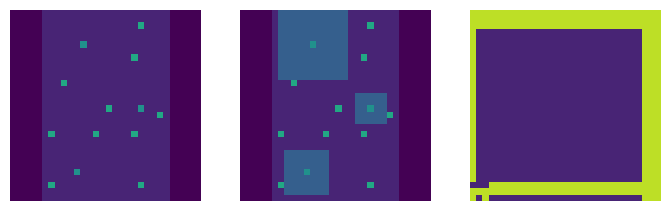

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.59s/it]


Epoch 38/500, Loss: 2.3408489325450543, Accuracy: 37.2511800233467%
Epoch 39/500


Validation:  89%|████████▉ | 8/9 [03:39<00:25, 25.92s/it]

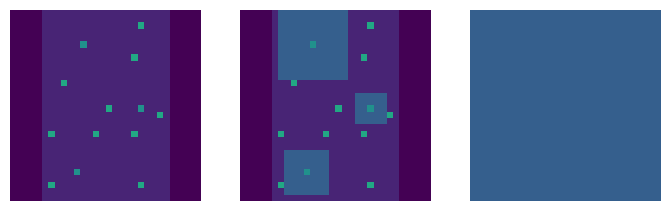

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.58s/it]


Epoch 39/500, Loss: 2.3098455540889202, Accuracy: 38.094706389889865%
Epoch 40/500


Validation:  89%|████████▉ | 8/9 [03:39<00:25, 25.98s/it]

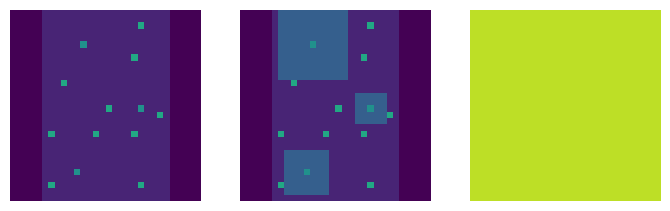

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.57s/it]


Epoch 40/500, Loss: 2.3943002085981617, Accuracy: 34.66781708369284%
Epoch 41/500


Validation:  89%|████████▉ | 8/9 [03:39<00:25, 25.98s/it]

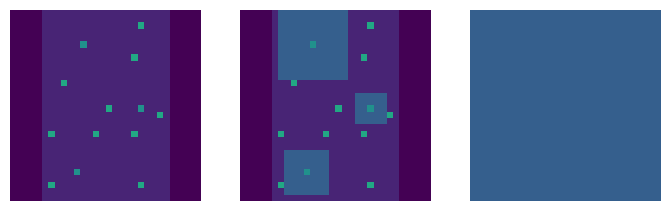

Validation: 100%|██████████| 9/9 [03:49<00:00, 25.53s/it]


Epoch 41/500, Loss: 2.321169761314028, Accuracy: 38.87123788255595%
Epoch 42/500


Validation:  89%|████████▉ | 8/9 [03:39<00:26, 26.03s/it]

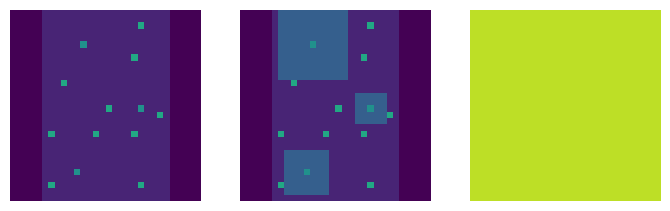

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.59s/it]


Epoch 42/500, Loss: 2.311771732099301, Accuracy: 38.106887276049335%
Epoch 43/500


Validation:  89%|████████▉ | 8/9 [03:40<00:26, 26.04s/it]

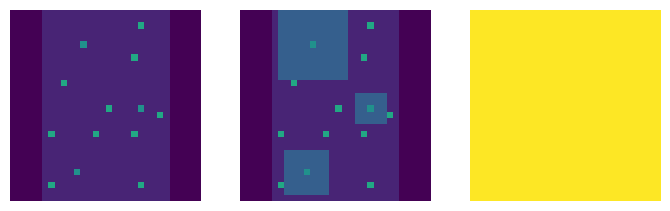

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.60s/it]


Epoch 43/500, Loss: 2.3316333053504654, Accuracy: 35.90823732426534%
Epoch 44/500


Validation:  89%|████████▉ | 8/9 [03:40<00:26, 26.14s/it]

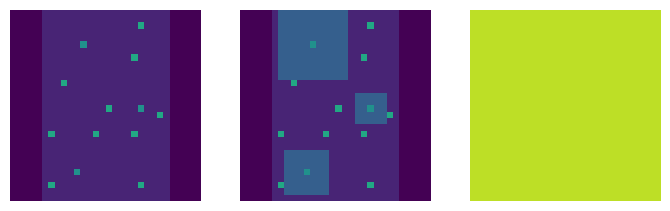

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.66s/it]


Epoch 44/500, Loss: 2.395427584221369, Accuracy: 35.88793584733289%
Epoch 45/500


Validation:  89%|████████▉ | 8/9 [03:40<00:25, 25.97s/it]

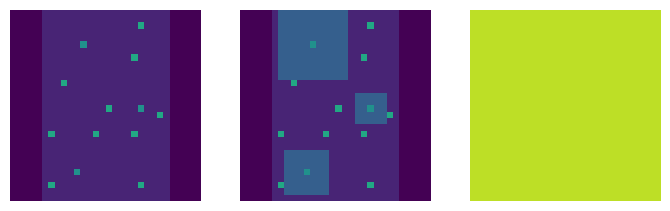

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.61s/it]


Epoch 45/500, Loss: 2.3066439830602494, Accuracy: 37.374003958788%
Epoch 46/500


Validation:  89%|████████▉ | 8/9 [03:40<00:25, 25.98s/it]

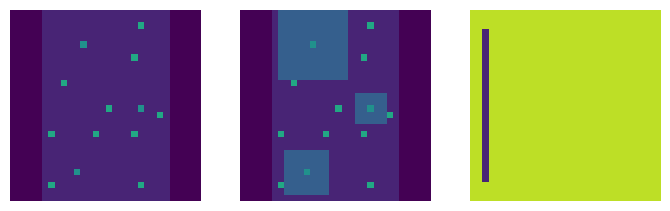

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.62s/it]


Epoch 46/500, Loss: 2.3502338015094293, Accuracy: 36.290920164441964%
Epoch 47/500


Validation:  89%|████████▉ | 8/9 [03:39<00:25, 25.96s/it]

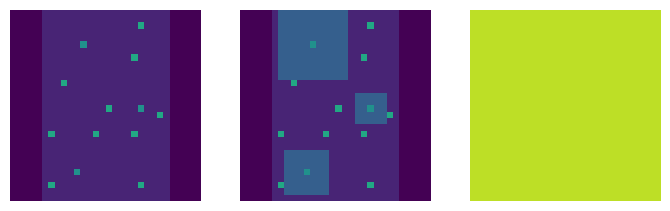

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.58s/it]


Epoch 47/500, Loss: 2.326614845624118, Accuracy: 36.73653758310917%
Epoch 48/500


Validation:  89%|████████▉ | 8/9 [03:40<00:26, 26.00s/it]

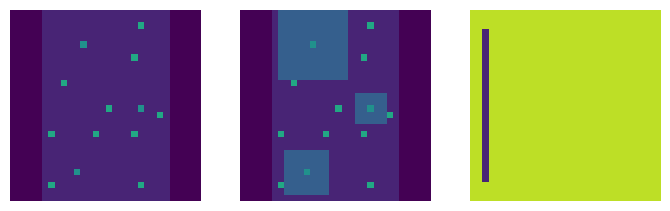

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.61s/it]


Epoch 48/500, Loss: 2.3340790283139397, Accuracy: 36.4015632137238%
Epoch 49/500


Validation:  89%|████████▉ | 8/9 [03:39<00:25, 25.88s/it]

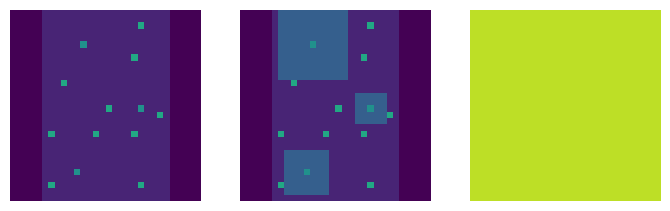

Validation: 100%|██████████| 9/9 [03:49<00:00, 25.52s/it]


Epoch 49/500, Loss: 2.3379293737092848, Accuracy: 37.65010404506928%
Epoch 50/500


Validation:  89%|████████▉ | 8/9 [03:40<00:26, 26.20s/it]

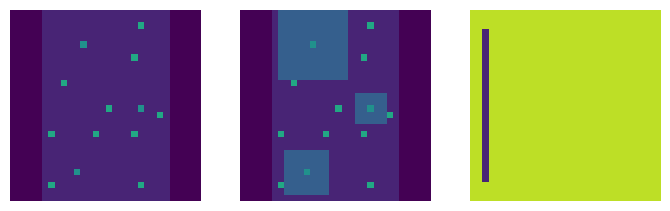

Validation: 100%|██████████| 9/9 [03:50<00:00, 25.66s/it]


Epoch 50/500, Loss: 2.3364859769623147, Accuracy: 37.3374613003096%
Epoch 51/500


Validation:  89%|████████▉ | 8/9 [03:41<00:26, 26.20s/it]

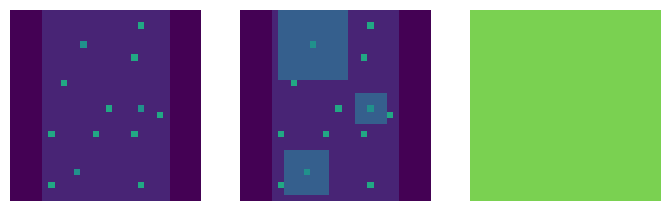

Validation: 100%|██████████| 9/9 [03:51<00:00, 25.77s/it]


Epoch 51/500, Loss: 2.3819286097774643, Accuracy: 37.11211490635944%
Epoch 52/500


Training:  78%|███████▊  | 7/9 [02:31<00:40, 20.20s/it]

In [9]:
import torch
from torch.utils.data import DataLoader
from dataloader_sw import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc



train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 500,
    'task_numbers': 50,  # equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 5,  # equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
}


def criterion(y_pred, y):
    y = y.long().squeeze(1)
    # print(y_pred.shape, y.shape)
    weight = torch.ones(model_args['num_classes']).to(y.device)
    weight[0] = 0.005
    weight[1] = 0.5
    ce = F.cross_entropy(y_pred, y, weight=weight)
    return ce

# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device
print(f'Using {device} device')

train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True, num_workers=8)

eval_dataset = ARC_Dataset(eval_challenge, eval_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False, num_workers=8)

# Outer Model 정의
outer_model = ARC_Net(**model_args).to(device)
outer_optimizer = optim.AdamW(outer_model.parameters(), lr=kwargs['outer_lr'])

# Inner Loop 업데이트 함수
def inner_loop_update(model, example_input, example_output, inner_optimizer, criterion, steps):
    for _ in range(steps):
        model.train()
        prediction = model(example_input)
        
        loss = criterion(prediction, example_output)

        inner_optimizer.zero_grad()
        loss.backward()
        inner_optimizer.step()

# Training Loop
for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    total_loss = 0
    outer_model.train()
    
    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]
        
        task_losses = []
        for task_number in range(input_tensor.shape[0]):
            # 모델의 가중치만 복사하여 이너 모델 초기화
            inner_model = ARC_Net(**model_args).to(device)
            inner_model.load_state_dict(outer_model.state_dict())
            
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])
            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                              inner_optimizer, criterion, kwargs['example_data_num'])
            
            inner_model.eval()
            task_prediction = inner_model(input_tensor[task_number])
            
            task_loss = criterion(task_prediction, output_tensor[task_number])
            task_losses.append(task_loss)
        
        meta_loss = torch.stack(task_losses).mean()
        outer_optimizer.zero_grad()
        meta_loss.backward()
        outer_optimizer.step()
        
        del meta_loss, task_losses
        gc.collect()
        torch.cuda.empty_cache()

    # Validation Loop
    outer_model.eval()
    validation_correct = 0
    validation_total_samples = 0
    total_loss = []

    for batch_idx, data in enumerate(tqdm(eval_loader, desc='Validation')):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]

        for task_number in range(input_tensor.shape[0]):
            inner_model = ARC_Net(**model_args).to(device)
            inner_model.load_state_dict(outer_model.state_dict())
            
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])
            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                            inner_optimizer, criterion, kwargs['example_data_num'])

            with torch.no_grad():
                inner_model.eval()
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                task_prediction = inner_model(task_input)
                task_loss = criterion(task_prediction, task_output)
                total_loss.append(task_loss.item())

                prediction_class = torch.argmax(task_prediction, dim=1, keepdim=True)

                mask = task_output != 0
                correct_predictions = (prediction_class == task_output) & mask
                validation_correct += correct_predictions.sum().item()
                validation_total_samples += mask.sum().item()

                if batch_idx == len(eval_loader) - 1 and task_number == input_tensor.shape[0] - 1:
                    show_grid_side_by_side(task_input.cpu(), task_output.cpu(), prediction_class.cpu())

            del inner_model, inner_optimizer, task_input, task_output, task_prediction, mask, correct_predictions
            gc.collect()
            torch.cuda.empty_cache()

    mean_loss = sum(total_loss) / len(total_loss) if total_loss else 0
    accuracy = 100 * validation_correct / validation_total_samples if validation_total_samples > 0 else 0
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {mean_loss}, Accuracy: {accuracy}%')
    torch.cuda.empty_cache()
